#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of the vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
E = 210e9

In [17]:
E*Ar

16991625880.187403

In [18]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [19]:
DT=np.diag(diag_DT) # (35) in [2]

In [20]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [21]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [22]:
CT=np.diag(diag_CT)

In [23]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [24]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [25]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [26]:
rng = np.random.default_rng()

In [27]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [28]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [29]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.8343806 , -0.21810503, -0.50620076],
       [ 0.17272822,  0.97558588, -0.13563613],
       [ 0.52342524,  0.025737  ,  0.85168282]])

In [30]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.009051


In [31]:
Ret.shape

(50, 3, 3)

In [32]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [33]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [34]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000939


In [35]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [36]:
fD(dx,dy,dz,DT,Ret).T

array([[ 18763.27519578,  45433.85768785,  -1317.76906145],
       [  6682.49129836,   4018.32868037,   1171.92568   ],
       [  -189.00570584,    -68.03764797,    868.2985742 ],
       [   182.5634431 , -24049.83208604,  -9941.75960766],
       [ 15679.0433203 ,   5402.816095  ,    153.92597728],
       [  1486.26442382,  -2768.24657483,   6755.73709879],
       [ 27286.48850166, -15331.40925861, -23745.55740691],
       [ 11436.91636619,   6297.04150357,    603.38983309],
       [ 10466.72425403,    192.79714648,   4121.91822561],
       [ -4035.19259255,   1433.77156226,   1391.64862097],
       [   716.69133735,    680.95110087,   -567.6186888 ],
       [   353.88634562,   1233.21516712,   -750.21199207],
       [ -2216.82810115, -13166.06249058,   8338.27025477],
       [  1945.57937053,   -666.04782178,   1153.5636217 ],
       [  8226.08289163,  -1037.09208405, -20171.60235514],
       [ -6592.87576257, -17040.05607543,   2357.65135678],
       [-18434.05047396,    560.71281758

In [37]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000361


In [38]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [39]:
I=np.identity(3)

In [40]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000405


In [41]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [42]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [43]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [44]:
DR=np.diag(diag_DR) 

In [45]:
Ar

0.08091250419136858

In [46]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [47]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [48]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [49]:
def Re_b(Ret):
    return Ret

In [50]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000160


In [51]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float32),B.T.astype(np.float32))

In [52]:
phi(x,y,z,Ret,None)

array([[ 0.43382698, -0.07507654, -0.7654224 ],
       [ 0.49022847, -0.40677527, -2.5006666 ],
       [ 0.54982835, -0.06198054,  0.3713572 ],
       [-1.573733  ,  1.2578802 ,  0.09684809],
       [-0.660571  ,  1.4365411 ,  0.2987249 ],
       [-0.1755028 , -0.92808133,  0.18442893],
       [ 0.19642673,  1.5284009 , -0.6483733 ],
       [ 0.9670065 ,  0.40817714,  0.51416564],
       [-0.58544034,  0.80863065, -0.49178734],
       [-0.90491426,  0.32519957, -1.300742  ],
       [ 0.9809479 ,  0.43754995,  0.6853199 ],
       [-0.2596879 ,  0.10107317, -1.3190582 ],
       [ 0.48053542,  0.30276117, -0.43755385],
       [-1.2031623 , -0.9354582 , -0.6947689 ],
       [-0.07521611, -0.4609867 ,  0.5367975 ],
       [ 0.8770511 , -0.0475947 , -1.7692479 ],
       [ 0.8793159 , -0.3134294 , -1.3740901 ],
       [ 0.33858484, -0.14783321,  0.6065471 ],
       [-1.2660323 ,  0.9568139 , -0.16789728],
       [ 0.22757918,  1.1404939 ,  0.23052776],
       [-1.9325067 ,  2.5785189 ,  0.736

In [53]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.001631


In [54]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [55]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [56]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.004607


In [57]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [58]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.004147


In [59]:
ωe(φ,θ,ψ,None,None)

array([[ 8.38858880e-03, -5.70985160e-01,  2.97699885e-01],
       [ 1.02264864e+00,  7.97304816e-01,  1.25931808e+00],
       [ 1.94744964e-01,  2.25111294e-01, -3.80805288e-01],
       [-4.22318635e-01,  7.58376044e-01,  3.13729383e-01],
       [-5.85961208e-01,  2.88898748e+00, -1.16292654e+00],
       [-8.95849807e-01,  2.76296950e+00, -6.49318279e-01],
       [ 6.12325303e-01,  1.93987179e+00,  9.26392550e-01],
       [-1.55901244e+00, -7.82841657e-01, -2.59828604e+00],
       [-1.09749077e+00,  6.19368173e-01, -7.14618658e-01],
       [-8.84836070e-01,  2.64790060e-01, -2.56987261e-01],
       [ 9.05885371e-01,  8.54661298e-01,  5.50952807e-01],
       [ 8.09251684e-01,  2.01045706e+00,  3.88760634e-01],
       [ 7.56366918e-01,  1.17470570e+00, -9.38566284e-01],
       [-7.56912522e-02, -7.79617595e-01,  4.72671482e-01],
       [-2.00196723e-01,  1.32603440e-01, -2.34259601e-01],
       [-1.58180216e+00, -2.58003546e+00, -1.36313222e+00],
       [-7.64492330e-01,  1.30835275e-01

In [60]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
  
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float32)).T

In [61]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [62]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-6.90338940e-06, -2.09387036e-05,  4.33333400e-06,
        -1.16102049e-05, -1.13780478e-05,  1.11249911e-05,
        -2.17675238e-05,  1.05987440e-06, -1.30040495e-05,
        -1.62592530e-05,  2.47767468e-06, -1.42011711e-05,
        -7.40307598e-06,  2.40686865e-06,  9.97774224e-06,
        -1.72163593e-05, -1.06065006e-05,  7.54372768e-06,
        -1.12469988e-05, -9.09956988e-06, -1.84186341e-05,
        -1.68883270e-05,  3.86272230e-05, -3.11848762e-06,
        -1.37255139e-05,  1.02733238e-05, -1.89079463e-05,
         1.94068519e-05,  1.28855045e-05, -8.36823627e-06,
         4.36688799e-06, -2.11895237e-05, -4.96253135e-06,
        -1.15517921e-05,  1.32816850e-05,  1.08155853e-05,
        -1.36988450e-05, -5.97109232e-06,  3.18223624e-06,
        -2.56250828e-05, -1.63616120e-05, -7.84343664e-07,
         4.51935415e-06, -5.36185969e-06,  7.17734838e-06,
        -2.91014984e-05, -1.83047429e-05,  1.42820819e-05,
         1.27647110e-05, -1.63793718e-05],
       [ 1.19

In [63]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.004154


In [64]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [65]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [66]:
d_s(ne,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-2.15277752e+02,  9.97779037e+00, -6.94882023e+01,
        -9.86878051e+01,  4.71556652e+00, -1.63391956e+01,
        -2.41290798e+01, -2.22001377e+01, -8.00074798e+00,
        -9.52116095e+01,  2.73717366e+02,  3.43774635e+02,
         1.98316717e+02, -1.33692234e+02, -1.40298059e+02,
         2.89212382e+02,  2.22454645e+02,  2.30023153e+02,
         3.77550485e+02, -3.32738386e+01,  6.47151479e+02,
        -5.03315015e+01,  4.67643011e+02,  6.84976209e+02,
        -3.18739640e+02,  4.22793884e+00,  1.88430115e+02,
         1.11142139e-01, -5.88937477e+01,  8.39082919e+01,
         1.05059143e+02, -2.99141056e+02, -4.29792369e+01,
         3.65282090e+02, -1.55528634e+02,  4.42498916e+01,
        -3.18736152e+02, -2.29810334e+02, -5.10654733e+01,
         1.13315742e+02, -2.43795520e+02, -7.64900823e+01,
         3.22120513e+02, -7.08976349e+01, -5.07514499e+02,
        -4.77334121e+02, -1.68749676e+01,  3.31968907e+02,
        -2.05536386e+02, -4.71840346e+00],
       [-2.01

In [67]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-7.87852988e-07,  1.79888907e-06,  7.91742515e-07,
        -1.11328711e-06, -1.43398030e-06,  1.31606787e-06,
         5.37276620e-07, -3.47370157e-08, -1.44065498e-06,
         5.37320247e-07, -1.15773359e-06, -2.42572958e-07,
        -9.27931988e-07,  5.27352579e-07,  8.23175589e-07,
        -5.91634068e-07, -2.34720710e-06,  6.87063884e-07,
        -5.02441260e-07, -1.81975039e-06,  1.22715183e-06,
        -4.48168004e-07,  1.04985353e-06, -1.33046047e-06,
        -2.53432675e-06,  3.41409424e-06, -1.55837342e-06,
         2.88285801e-07,  5.57036199e-07,  1.95947033e-07,
        -8.89513093e-07,  4.82848115e-07,  3.44479931e-08,
        -3.86000306e-07,  1.46653553e-06,  1.20280765e-06,
        -1.40580425e-06,  4.33976543e-07, -5.19272999e-07,
        -1.97170978e-06, -1.17253332e-06,  1.87429955e-07,
         4.24569628e-07,  6.67886422e-07,  2.13271452e-06,
        -3.38412720e-06,  5.09665530e-07,  1.80349467e-06,
        -2.16430447e-07, -2.03574751e-07],
       [ 1.11

In [68]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [69]:
ne_(dx,dy,dz,DT,Ret)

array([[-18763.27519578,  -6682.49129836,    189.00570584,
          -182.5634431 , -15679.0433203 ,  -1486.26442382,
        -27286.48850166, -11436.91636619, -10466.72425403,
          4035.19259255,   -716.69133735,   -353.88634562,
          2216.82810115,  -1945.57937053,  -8226.08289163,
          6592.87576257,  18434.05047396,   6407.53171683,
          2243.38881978,    -61.72195645,  -4888.23714166,
        -13867.90451495,  -5008.10193978,  -1723.94279689,
        -25779.24717003,  -2650.39130066,   3036.90019946,
         -2887.14954891,  -9503.09596446,   -509.44278262,
          2424.11712348,   4223.33468478,  -1295.46732194,
          2658.05273022,   5305.55475254,  -4152.1020716 ,
         13036.89735594,   3040.93570811,  18173.95382711,
           -97.42720749,  14339.10201352, -12758.13923582,
           763.66718973,   5100.027216  ,  -7067.146551  ,
         11964.43000963,   7430.09568281,    180.39825009,
         -3407.5426466 ,  17693.16711138],
       [-4543

In [70]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.007476


In [71]:
d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

array([[-9.73286796e+07,  6.09337552e+08, -1.14931002e+08],
       [-4.81884046e+06, -4.87236800e+06, -1.52109047e+05],
       [-1.09883429e+08, -4.02126566e+08,  9.55764468e+07],
       [ 2.30063001e+08,  2.93476279e+08, -7.33135041e+07],
       [ 4.21245004e+06,  1.66647903e+06,  1.30105215e+06],
       [-5.83158047e+07,  1.05206220e+07, -2.55163070e+06],
       [-6.76892569e+06, -1.58697683e+08, -3.76146392e+08],
       [-4.33715299e+07, -3.85204624e+08,  3.87369860e+08],
       [ 1.03654855e+07,  5.05126620e+06, -4.03378558e+06],
       [ 1.08184552e+08,  1.44137470e+08, -3.92270709e+07],
       [ 1.60504253e+08, -1.23285460e+08, -1.51028396e+08],
       [-4.48465376e+08,  7.95960900e+05,  8.83520409e+07],
       [-5.30079911e+07,  1.01409123e+08,  1.19540198e+07],
       [ 1.82801868e+08, -2.02641577e+08, -4.37233120e+07],
       [-1.92341873e+08, -4.50640000e+08, -4.13947988e+08],
       [-2.98512286e+08, -3.29758916e+07, -1.47091347e+08],
       [-8.95909806e+07, -1.52826055e+08

In [72]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-5.80888743e+08, -1.64396009e+08, -3.79673997e+08],
       [ 6.34307848e+04, -3.62916375e+05,  9.61488398e+06],
       [-7.95583143e+08,  2.63513552e+08,  1.94025281e+08],
       [-3.23397759e+08,  3.05075060e+08,  2.06387165e+08],
       [ 1.29028713e+05, -2.25113125e+06,  2.46443994e+06],
       [ 9.74074150e+06,  6.60486724e+07,  4.97094604e+07],
       [ 2.47881401e+08,  1.38325058e+07, -1.02965977e+07],
       [-1.82113171e+08,  3.23716302e+08,  3.01516113e+08],
       [-4.38461419e+06,  1.29463067e+07,  4.94555122e+06],
       [-1.17513398e+08,  8.55796947e+07, -9.63200869e+06],
       [-2.34526442e+07, -1.64422647e+08,  1.09294998e+08],
       [ 8.90263548e+04, -3.40257706e+08,  3.51728338e+06],
       [-2.81855499e+08, -1.52705947e+08,  4.56109659e+07],
       [-3.55273444e+08, -2.39885169e+08, -3.73577541e+08],
       [-8.55930916e+08,  2.57587775e+08,  1.17289572e+08],
       [-4.27427773e+07, -1.65391270e+08,  1.23821409e+08],
       [-1.91493276e+07, -1.87305328e+07

In [73]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000408


In [74]:
Re_b(Ret).shape

(50, 3, 3)

In [75]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans


In [76]:
Irho_e(Ret).shape

(50, 3, 3)

In [77]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000209


In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.005620


In [82]:
d_me_

array([[ 6.96224703e-14,  4.41264154e-09, -3.36304568e-09],
       [ 1.59063172e-16,  1.68415898e-12, -2.64206209e-09],
       [ 8.58640861e-14,  3.91753317e-09, -4.28150089e-09],
       [ 4.71171002e-14,  3.17267549e-09, -1.66545009e-09],
       [ 2.55359380e-16,  4.54009754e-09, -1.14406491e-11],
       [ 4.56121847e-15,  4.15936352e-09, -2.36586606e-10],
       [ 3.94625072e-14,  8.30837113e-11, -4.87522685e-10],
       [ 3.21303404e-14,  3.90494820e-09, -1.91841646e-09],
       [ 2.67900168e-15,  6.08473286e-11, -1.92964838e-09],
       [ 2.39926558e-14,  4.55239803e-10, -2.06896567e-09],
       [ 8.19374588e-15,  8.44165974e-10, -1.58194943e-09],
       [ 1.99392718e-16,  3.85641302e-09, -1.78924410e-11],
       [ 4.29904230e-14,  1.72153078e-09, -3.33949831e-10],
       [ 5.01644764e-14,  4.14681908e-09, -2.65230921e-09],
       [ 9.01530621e-14,  4.14153231e-09, -4.38740713e-09],
       [ 1.22253534e-14,  8.52113223e-10, -2.20199280e-09],
       [ 7.15795378e-15,  9.38181430e-11

In [83]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [84]:
ne_(dx,dy,dz,DT,Ret)

array([[-18763.27519578,  -6682.49129836,    189.00570584,
          -182.5634431 , -15679.0433203 ,  -1486.26442382,
        -27286.48850166, -11436.91636619, -10466.72425403,
          4035.19259255,   -716.69133735,   -353.88634562,
          2216.82810115,  -1945.57937053,  -8226.08289163,
          6592.87576257,  18434.05047396,   6407.53171683,
          2243.38881978,    -61.72195645,  -4888.23714166,
        -13867.90451495,  -5008.10193978,  -1723.94279689,
        -25779.24717003,  -2650.39130066,   3036.90019946,
         -2887.14954891,  -9503.09596446,   -509.44278262,
          2424.11712348,   4223.33468478,  -1295.46732194,
          2658.05273022,   5305.55475254,  -4152.1020716 ,
         13036.89735594,   3040.93570811,  18173.95382711,
           -97.42720749,  14339.10201352, -12758.13923582,
           763.66718973,   5100.027216  ,  -7067.146551  ,
         11964.43000963,   7430.09568281,    180.39825009,
         -3407.5426466 ,  17693.16711138],
       [-4543

### Static solution

In [85]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [86]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [87]:
Fx_0=82945396

In [88]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [89]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [90]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [91]:
delta_x=horizontal_length/(node_N-1)

In [92]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [93]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [94]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

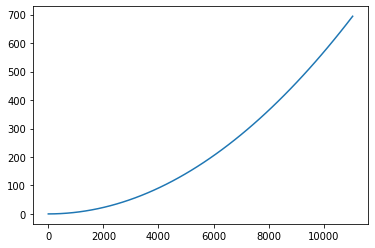

In [95]:
plt.plot(x0, z0)
plt.show()

In [96]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [97]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [98]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T

############################################################    

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [99]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [100]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [101]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [103]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [104]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [105]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [106]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

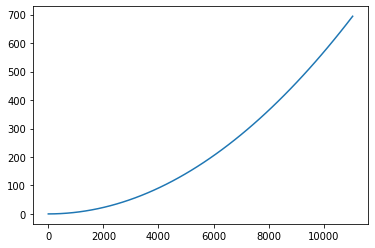

In [107]:
plt.plot(x0_, z0_)
plt.show()

In [108]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_

In [109]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Vessle Simulation

In [110]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [111]:
vehicle=semisub('DPcontrol',2,2,40.0,0,0) 

In [112]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [113]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

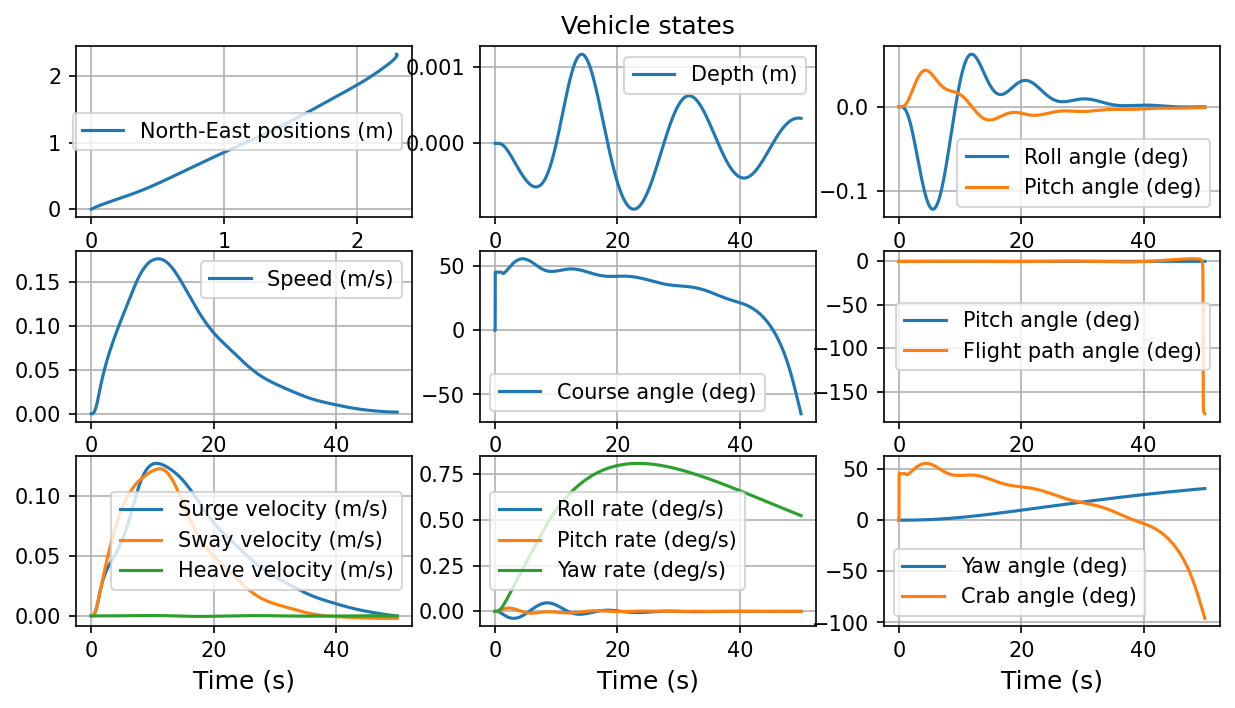

In [ ]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [ ]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

In [ ]:
plotVehicleStates(simTime, simData, 3)

In [ ]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [ ]:
def grayscott1d(t, Q):
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
    n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
    force_schedule = 1e3
    tau_force = force_schedule*0.0166666667*n_ # [N]

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)
    
    Z0=np.dot(Re_b(Ret),tau_force[:3])   
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 +Z0)

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N-1)]
                                             +[vessel_mass]
                                             ,RRRR),
                                   Z).T 
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [ ]:
tspan = (0., 40)

In [ ]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()